# Solving an electric circuit using Particle Swarm Optimization

## Introduction

PSO can be utilized in a wide variety of fields. In this example, the problem consists of analysing a given electric circuit and finding the electric current that flows through it. To accomplish this, the ```pyswarms``` library will be used to solve a non-linear equation by restructuring it as an optimization problem. The circuit is composed by a source, a resistor and a diode, as shown below.

![Circuit](https://user-images.githubusercontent.com/39431903/43938822-29aaf9b8-9c66-11e8-8e54-01530db005c6.png)


### Mathematical Formulation

Kirchhoff's voltage law states that the directed sum of the voltages around any closed loop is zero. In other words, the sum of the voltages of the passive elements must be equal to the sum of the voltages of the active elements, as expressed by the following equation:

$U = v_D + v_R $, where $U$ represents the voltage of the source and, $v_D$ and $v_R$ represent the voltage of the diode and the resistor, respectively.

To determine the current flowing through the circuit, $v_D$ and $v_R$ need to be defined as functions of $I$. A simplified Shockley equation will be used to formulate the current-voltage characteristic function of the diode. This function relates the current that flows through the diode with the voltage across it. Both $I_s$ and $v_T$ are known properties.

$I = I_s  e^{\frac{v_D}{v_T}}$

Where:

- $I$ : diode current
- $I_s$ : reverse bias saturation current
- $v_D$ : diode voltage
- $v_T$ : thermal voltage

Which can be formulated over $v_D$:

$v_D = v_T \log{\left |\frac{I}{I_s}\right |}$

The voltage over the resistor can be written as a function of the resistor's resistance $R$ and the current $I$:

$v_R = R  I$

And by replacing these expressions on the Kirschhoff's voltage law equation, the following equation is obtained:

$U = v_T \log{\left |\frac{I}{I_s}\right |} + R I$


To find the solution of the problem, the previous equation needs to be solved for $I$, which is the same as finding $I$ such that the cost function $c$ equals zero, as shown below. By doing this, solving for $I$ is restructured as a minimization problem. The absolute value is necessary because we don't want to obtain negative currents.

$c = \left | U - v_T \log{\left | \frac{I}{I_s} \right |} - RI \right |$



### Known parameter values

The voltage of the source is $10 \space V$ and the resistance of the resistor is $100 \space \Omega$. The diode is a silicon diode and it is assumed to be at room temperature.

$U = 10 \space V$

$R = 100 \space \Omega$

$I_s = 9.4 \space pA = 9.4 \times 10^{-12} \space A$ (reverse bias saturation current of silicon diodes at room temperature, $T=300 \space K$)

$v_T = 25.85 \space mV = 25.85 \times 10^{-3} \space V$ (thermal voltage at room temperature, $T=300 \space K$)

## Optimization

In [1]:
# Import modules
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import PySwarms
import pyswarms as ps

In [2]:
print('Running on Python version: {}'.format(sys.version))

Running on Python version: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


### Defining the cost fuction

The first argument of the cost function is a ```numpy.ndarray```. Each dimension of this array represents an unknown variable. In this problem, the unknown variable is just $I$, thus the first argument is a unidimensional array. As default, the thermal voltage is assumed to be $25.85 \space mV$.

In [3]:
def cost_function(I):
    
    #Fixed parameters
    U = 10
    R = 100
    I_s = 9.4e-12
    v_t = 25.85e-3
    
    c = abs(U - v_t * np.log(abs(I[:, 0] / I_s)) - R * I[:, 0])
    
    return c  

### Setting the optimizer

To solve this problem, the global-best optimizer is going to be used. 

In [4]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.3}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options=options)

# Perform optimization
cost, pos = optimizer.optimize(cost_function, iters=30)

2019-05-18 15:41:35,474 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.3}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=14 
2019-05-18 15:41:35,863 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.045352861989468, best pos: [0.23426529]


CPU times: user 111 ms, sys: 12.1 ms, total: 123 ms
Wall time: 411 ms


In [5]:
print(pos[0])

0.23426529444241187


In [6]:
print(cost)

14.045352861989468


### Checking the solution

The current flowing through the circuit is approximately $0.094 \space A$ which yields a cost of almost zero. The graph below illustrates the relationship between the cost $c$ and the current $I$. As shown, the cost reaches its minimum value of zero when $I$ is somewhere close to $0.09$.

The use of ```reshape(100, 1)``` is required since ```np.linspace(0.001, 0.1, 100)``` returns an array with shape ```(100,)``` and first argument of the cost function must be a unidimensional array, that is, an array with shape ```(100, 1)```. 

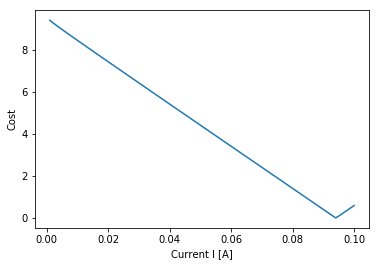

In [7]:
x = np.linspace(0.001, 0.1, 100).reshape(100, 1)
y = cost_function(x)

plt.plot(x, y)
plt.xlabel('Current I [A]')
plt.ylabel('Cost');

Another way of solving non-linear equations is by using non-linear solvers implemented in libraries such as ```scipy```. There are different solvers that one can choose which correspond to different numerical methods. We are going to use ```fsolve```, which is a general non-linear solver that finds the root of a given function. 

Unlike ```pyswarms```, the function (in this case, the cost function) to be used in ```fsolve``` must have as first argument a single value. Moreover, numerical methods need an initial guess for the solution, which can be made from the graph above. 

In [8]:
# Import non-linear solver
from scipy.optimize import fsolve

In [9]:
c = lambda I: abs(10 - 25.85e-3 * np.log(abs(I / 9.4e-12)) - 100 * I)

initial_guess = 0.09

current_I = fsolve(func=c, x0=initial_guess)

print(current_I[0])

0.09404768643017938


The best solution value found using the PSO method was approximately the same as the one found using a non-linear solver, about $0.094 \space A$. In fact, the relative error was less than $1 \times 10^{-5}$.